# Linear Models

In [1]:
import numpy as np
import pandas as pd
from patsy import dmatrix,demo_data
import pystan
import matplotlib.pyplot as plt

## General Model Specification

Let $N$  be the number of data points $(\mathbf{X},\mathbf{y})=\{(\mathbf{x}_n, y_n)\}$. A linear model for  the data assumes a linear relationship between the inputs $\mathbf{x}\in\{0,1, \cdots, D-1\}$ and the outputs $y\in\mathbb{R}$ and has the following parameters.

1. $\beta$  model's weights.
2. $\sigma_{\beta}^2$ is (known) prior variance.
3. $\sigma_y^2$ is (known) likelihood variance.

The joint distribution of the data and parameters is 

\begin{align*}
 p(\mathbf{y}, \mathbf{X},\beta,\sigma_y^2,\sigma_{\beta}^2)= \text{Normal}(\beta \mid \mathbf{0}, \sigma_{\beta}^2\mathbf{I})\prod_{n=1}^N  \text{Normal}(y_n \mid \mathbf{x}_n^\top\beta , \sigma_y^2)
\end{align*}

The hierarchical model can be specified as such

\begin{align*}
  \beta
  &\sim
  \text{Normal}( \mathbf{0}, \sigma_{\beta}^2\mathbf{I}),
  \\[1.5ex]
  y_n \mid (\mathbf{x}_n, \beta)
  &\sim
  \text{Normal}(\mathbf{x}_n^\top\beta , \sigma_y^2)
\end{align*}



## Data

### One categorical variable with one level

In [2]:
def build_dataset_linear_model_categorical_1(N, beta, noise_std):
  D = len(beta)
  X = dmatrix('-1+a', data=demo_data( "a", nlevels=D, min_rows=N), return_type='dataframe')
  y = np.dot(X.values, beta) + np.random.normal(0, noise_std, size=(N,1))
  return X, y

In [119]:
N = 1000  # number of data points
D=25
noise_beta=np.sqrt(.5)
beta_true= np.random.normal(0, noise_beta, size=(D,1))
noise_std=0.5
X_train, y_train = build_dataset_linear_model_categorical_1(N, beta_true,noise_std)
df_train=pd.DataFrame(y_train,columns=['y']).join(X_train)
df_train.head()

,y,a[a1],a[a10],a[a11],a[a12],a[a13],a[a14],a[a15],a[a16],a[a17],...,a[a23],a[a24],a[a25],a[a3],a[a4],a[a5],a[a6],a[a7],a[a8],a[a9]
0,1.039428,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.806684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.725571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.050348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.432565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


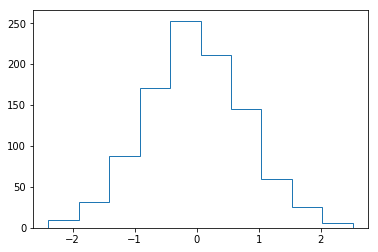

In [120]:
plt.hist(y_train, histtype='step')
plt.show()

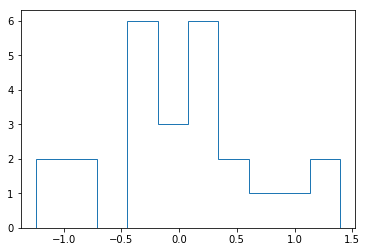

In [121]:
plt.hist(beta_true,10, histtype='step')
plt.show()

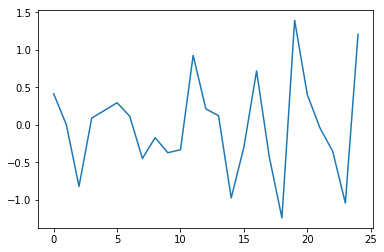

In [122]:
plt.plot(beta_true)
plt.show()

## Inference

In [123]:
x=df_train.iloc[:,1:].apply(lambda x: np.where(x>0)[0][0]+1, axis=1).tolist()
x[:5]

[1, 12, 19, 20, 21]

In [124]:
y=list(df_train['y'].values)
y[:5]

[1.0394279963307995,
 0.8066839382983133,
 -0.7255713241116944,
 2.0503477348248826,
 0.43256529515474296]

In [125]:
code = """
functions {
matrix make_X(int N, int D, int[] J) {
    matrix[N, D] X = rep_matrix(0, N, D); #initialize with zeros
    for (i in 1:N){
      X[i, J[i]] = 1.0;
    }
    return X;
  }
}

data {
  int<lower=0> N;
  vector[N] y;
  int x[N];  // group membership variable
}

transformed data { 
  real sigma=0.5;
  int<lower=1> D = max(x); 
  matrix[N, D] X = make_X(N, D, x);
} 

parameters {
  vector[D] beta;
}

model {
  y ~ normal(X * beta, sigma);
}

generated quantities {
   real y_sim[N];
   for(n in 1:N) { 
    y_sim[n] = normal_rng(X[n] * beta, sigma);
   }
}

"""

dat = {'N': N,
       'x': x,
       'y': y}

sm = pystan.StanModel(model_code=code)
fit = sm.sampling(data=dat, iter=2000, chains=4)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cc681ed11c9cac31db57d618d7e0a1c7 NOW.
/home/rick/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [126]:
print(fit)

Inference for Stan model: anon_model_cc681ed11c9cac31db57d618d7e0a1c7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]      0.21  1.2e-3   0.08   0.06   0.16   0.21   0.26   0.36   4000    1.0
beta[1]      0.08  1.2e-3   0.08  -0.08   0.03   0.08   0.13   0.23   4000    1.0
beta[2]     -0.86  1.3e-3   0.08  -1.02  -0.91  -0.86   -0.8   -0.7   4000    1.0
beta[3]      0.12  1.2e-3   0.08  -0.03   0.07   0.12   0.17   0.28   4000    1.0
beta[4]      0.15  1.3e-3   0.08-8.2e-3    0.1   0.15    0.2   0.31   4000    1.0
beta[5]      0.28  1.2e-3   0.08   0.13   0.23   0.28   0.34   0.43   4000    1.0
beta[6]      0.04  1.2e-3   0.08  -0.12  -0.01   0.04   0.09   0.19   4000    1.0
beta[7]     -0.51  1.2e-3   0.08  -0.66  -0.56  -0.51  -0.46  -0.36   4000    1.0
beta[8]     -0.11  1.2e-3   0.08  -0.26  -0.17  -0.11  -0.06   0.04   400

In [127]:
beta_hat = fit.extract(permuted=True)['beta']

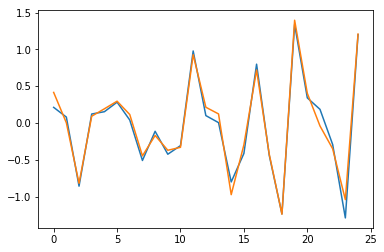

In [128]:
fig, ax = plt.subplots(1, 1)
ax.plot(beta_hat.mean(0))
ax.plot(beta_true)
plt.show()

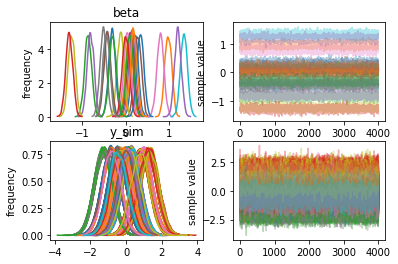

In [129]:

# if matplotlib is installed (optional, not required), a visual summary and
# traceplot are available
fit.plot()
plt.show()

## Posterior Checks

In [130]:
y_sim = fit.extract(permuted=True)['y_sim']
y_sim.shape

(4000, 1000)

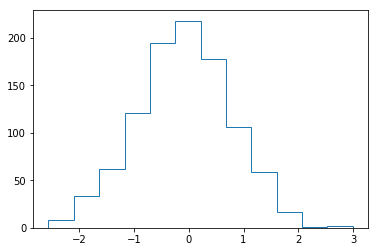

In [131]:
plt.hist(y_sim[3999,:], 12, histtype='step')
plt.show()

# Laplace distribution on beta

For $\beta=1$ it is identical to a Laplace distribution. For $\beta = 2$, it is identical to a normal distribution with scale $1/\sqrt 2$

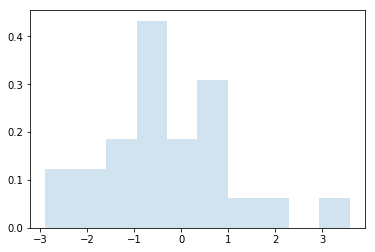

In [138]:
from scipy.stats import gennorm
D=25
beta_true= gennorm.rvs(1, size=(D,1))
 
fig, ax = plt.subplots(1, 1)
ax.hist(beta_true,10, normed=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()



In [139]:
N = 1000  # number of data points
noise_std=0.5
X_train, y_train = build_dataset_linear_model_categorical_1(N, beta_true,noise_std)
df_train=pd.DataFrame(y_train,columns=['y']).join(X_train)
df_train.head()

,y,a[a1],a[a10],a[a11],a[a12],a[a13],a[a14],a[a15],a[a16],a[a17],...,a[a23],a[a24],a[a25],a[a3],a[a4],a[a5],a[a6],a[a7],a[a8],a[a9]
0,0.238433,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.401083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.675845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.786439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.084541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [140]:
y=list(df_train['y'].values)
y[:5]

[0.2384325388634642,
 -0.4010828792756049,
 -0.6758449461243491,
 -0.7864386982716081,
 0.08454068922552366]

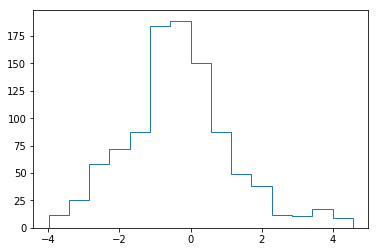

In [141]:
plt.hist(y_train,15, histtype='step')
plt.show()

# Inference

In [142]:

dat = {'N': N,
       'x': x,
       'y': y}

sm = pystan.StanModel(model_code=code)
fit2 = sm.sampling(data=dat, iter=2000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_755766a17661530be68e4c77eadf1972 NOW.
/home/rick/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [143]:
print(fit2)

Inference for Stan model: anon_model_755766a17661530be68e4c77eadf1972.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]      0.33  1.2e-3   0.08   0.18   0.28   0.33   0.39   0.49   4000    1.0
beta[1]     -0.19  1.2e-3   0.08  -0.34  -0.24  -0.19  -0.14  -0.04   4000    1.0
beta[2]      0.23  1.2e-3   0.08   0.08   0.18   0.23   0.28   0.38   4000    1.0
beta[3]     -0.54  1.2e-3   0.08   -0.7   -0.6  -0.55  -0.49  -0.39   4000    1.0
beta[4]      0.85  1.2e-3   0.08    0.7    0.8   0.85    0.9    1.0   4000    1.0
beta[5]      1.41  1.2e-3   0.08   1.25   1.35   1.41   1.46   1.56   4000    1.0
beta[6]     -0.59  1.2e-3   0.08  -0.74  -0.64  -0.59  -0.53  -0.43   4000    1.0
beta[7]     -0.95  1.2e-3   0.08  -1.11  -1.01  -0.95   -0.9   -0.8   4000    1.0
beta[8]      0.42  1.2e-3   0.08   0.27   0.37   0.42   0.48   0.58   400

In [144]:
beta_hat = fit2.extract(permuted=True)['beta']

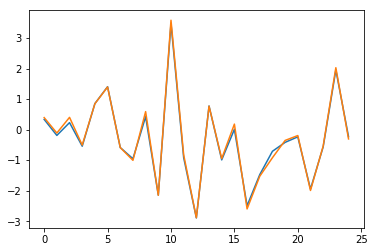

In [145]:
fig, ax = plt.subplots(1, 1)
ax.plot(beta_hat.mean(0))
ax.plot(beta_true)
plt.show()

In [134]:
code = """
functions {
matrix make_X(int N, int D, int[] J) {
    matrix[N, D] X = rep_matrix(0, N, D); #initialize with zeros
    for (i in 1:N){
      X[i, J[i]] = 1.0;
    }
    return X;
  }
}

data {
  int<lower=0> N;
  vector[N] y;
  int x[N];  // group membership variable
}

transformed data { 
  real sigma=0.5;
  int<lower=1> D = max(x); 
  matrix[N, D] X = make_X(N, D, x);
} 

parameters {
  vector[D] beta;
}

model {  
  beta ~ normal(0, .5);
  y ~ normal(X * beta, sigma);
}

generated quantities {
   real y_sim[N];
   for(n in 1:N) { 
    y_sim[n] = normal_rng(X[n] * beta, sigma);
   }
}

"""

dat = {'N': N,
       'x': x,
       'y': y}

sm2 = pystan.StanModel(model_code=code)
fit3 = sm2.sampling(data=dat, iter=2000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_755766a17661530be68e4c77eadf1972 NOW.
/home/rick/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [135]:
beta_hat = fit3.extract(permuted=True)['beta']

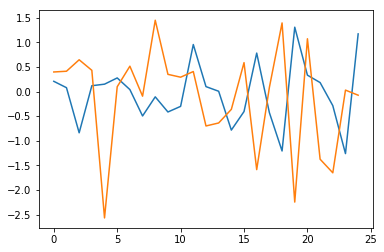

In [136]:
fig, ax = plt.subplots(1, 1)
ax.plot(beta_hat.mean(0))
ax.plot(beta_true)
plt.show()

In [137]:
print(fit3)

Inference for Stan model: anon_model_755766a17661530be68e4c77eadf1972.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]      0.21  1.2e-3   0.08   0.06   0.15   0.21   0.26   0.36   4000    1.0
beta[1]      0.08  1.3e-3   0.08  -0.07   0.02   0.08   0.13   0.23   4000    1.0
beta[2]     -0.84  1.2e-3   0.08  -0.99  -0.89  -0.84  -0.78  -0.69   4000    1.0
beta[3]      0.12  1.2e-3   0.08  -0.04   0.07   0.12   0.17   0.27   4000    1.0
beta[4]      0.15  1.2e-3   0.08-7.4e-3    0.1   0.15    0.2    0.3   4000    1.0
beta[5]      0.28  1.2e-3   0.08   0.12   0.22   0.28   0.33   0.43   4000    1.0
beta[6]      0.04  1.3e-3   0.08  -0.12  -0.02   0.04   0.09    0.2   4000    1.0
beta[7]      -0.5  1.2e-3   0.08  -0.65  -0.55   -0.5  -0.45  -0.34   4000    1.0
beta[8]     -0.11  1.2e-3   0.08  -0.26  -0.16  -0.11  -0.06   0.04   400